In [1]:
from os import listdir
import numpy as np
from PIL import Image

LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'

def load_labels():
    paths = [f"{LABELS_PATH}/{path}" for path in sorted(listdir(LABELS_PATH))]
    return [(np.asarray(Image.open(path).convert('L')) > 30).astype(int) for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

LABELS = load_labels()
MASKS = load_masks()

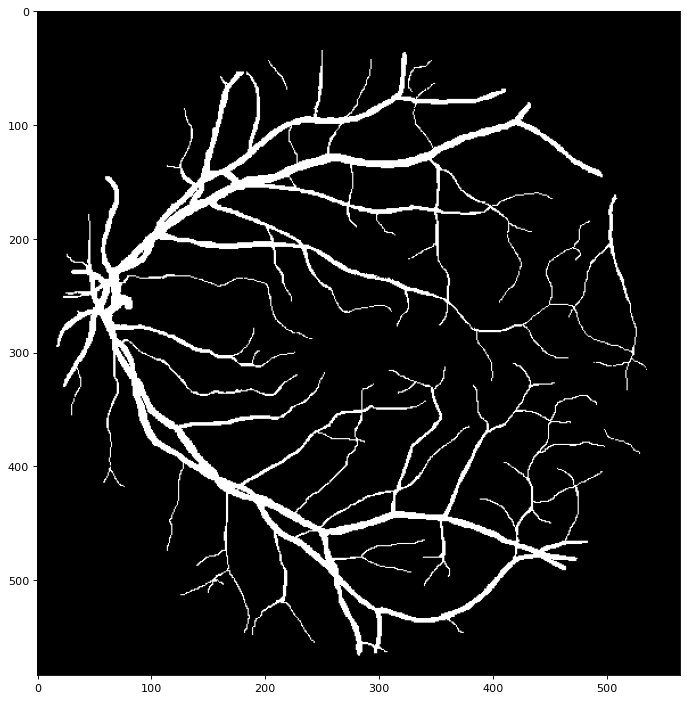

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.figure(figsize=(15, 11), dpi=80)
    plt.imshow(img, cmap='gray')
    
imshow(LABELS[0])

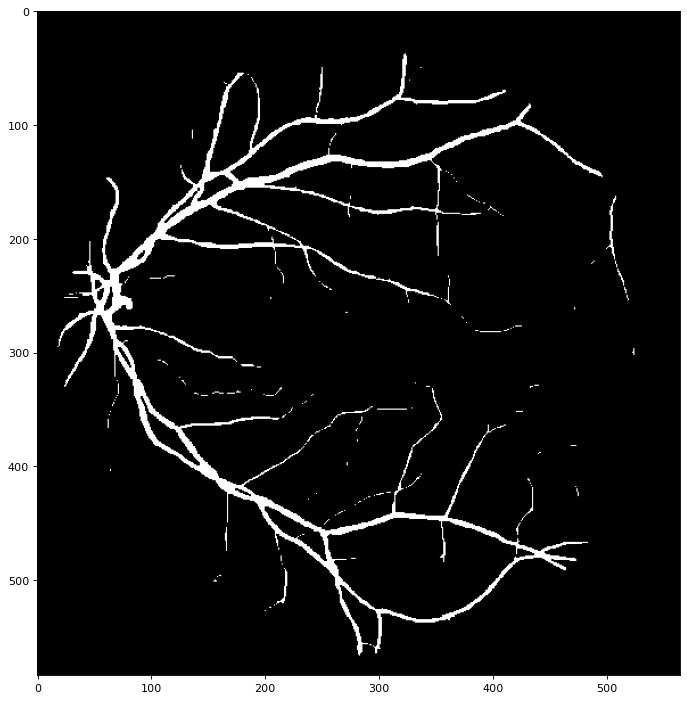

In [3]:
import cv2 as cv

kernel = np.ones((2,2),np.uint8)
img = np.clip(cv.erode(LABELS[0].astype(np.uint8), kernel, iterations = 1), 0, 1)

imshow(img)

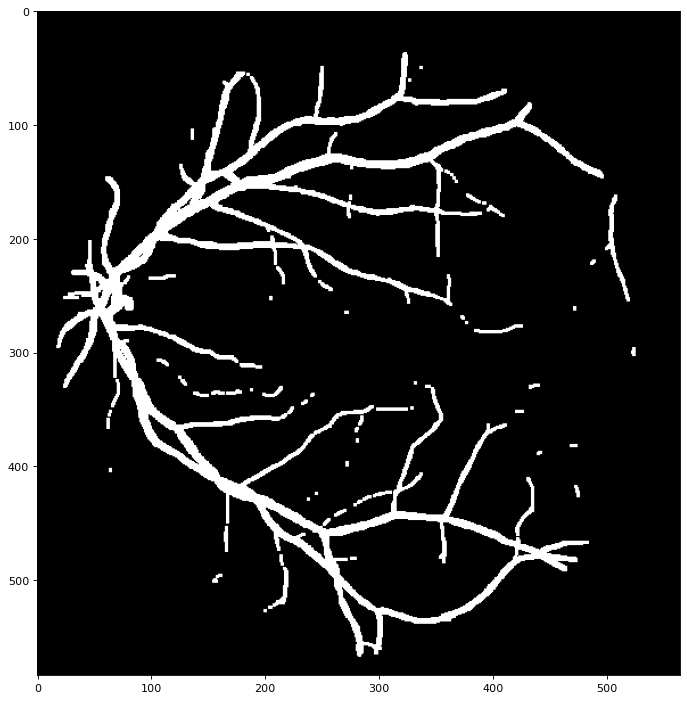

In [4]:
kernel = np.ones((3,3),np.uint8)
img = np.clip(cv.dilate(img, kernel, iterations = 1), 0, 1)

imshow(img)

In [5]:
result =np.clip(LABELS[0] - img, 0, 1) * LABELS[0]

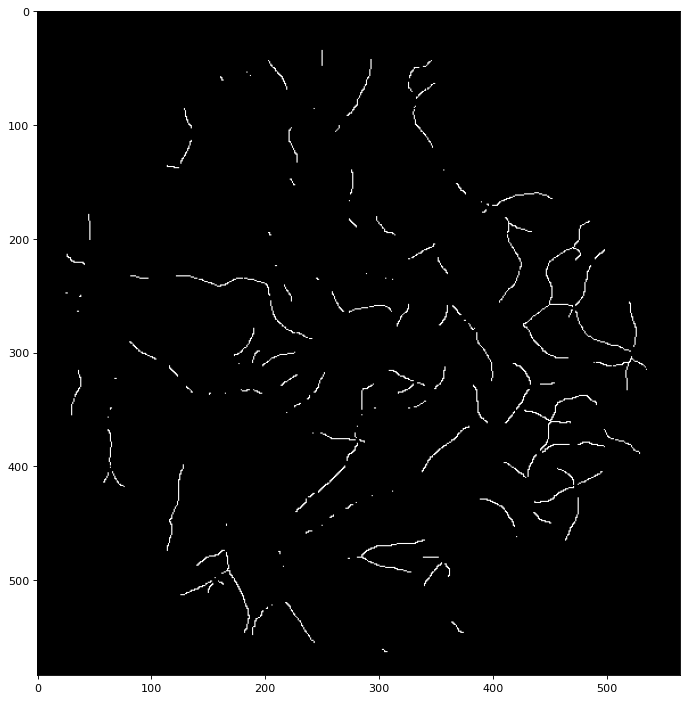

In [6]:
imshow(result)

In [7]:
def thin_veins_img(original_img):
    kernel = np.ones((2,2), np.uint8)
    img = np.clip(cv.erode(original_img.astype(np.uint8), kernel, iterations = 1), 0, 1)
    kernel = np.ones((3,3), np.uint8)
    img = np.clip(cv.dilate(img, kernel, iterations = 1), 0, 1)
    return np.clip(original_img - img, 0, 1) * original_img

In [8]:
NEW_LABELS = [thin_veins_img(l) for l in LABELS]

In [9]:
def imshow_comparison(img1, img2):
    plt.figure(figsize=(15, 11), dpi=80)
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')

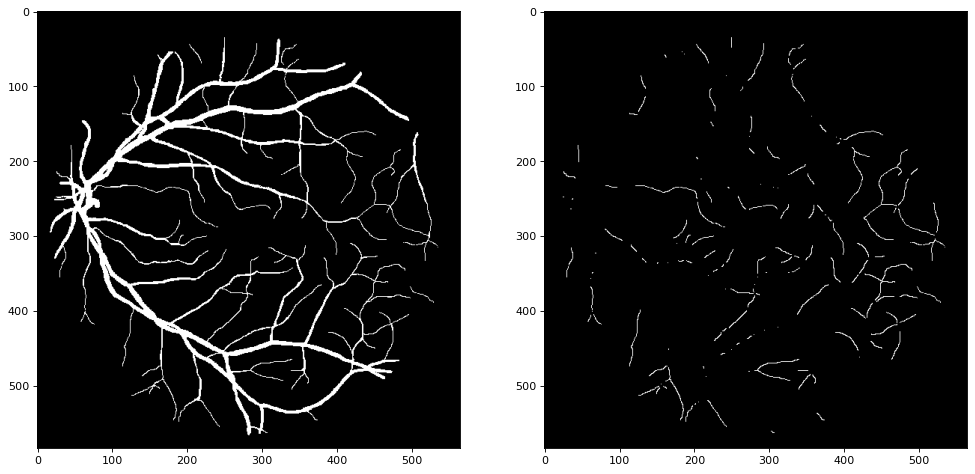

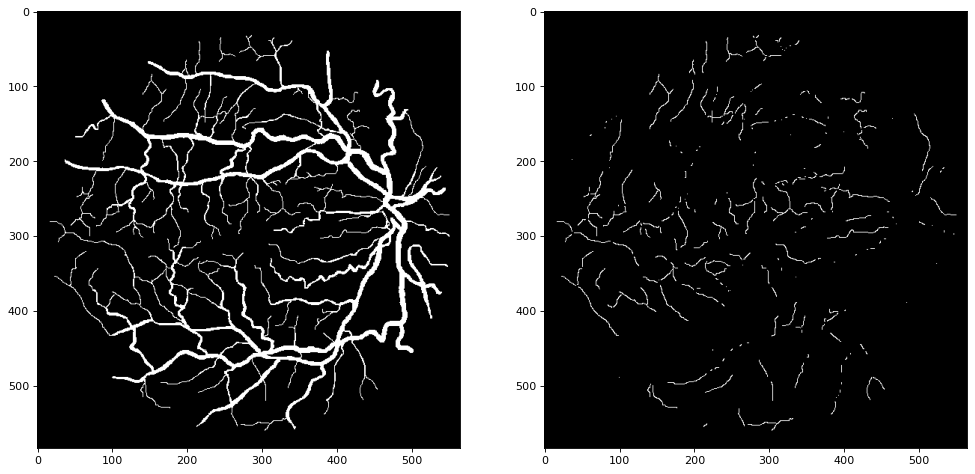

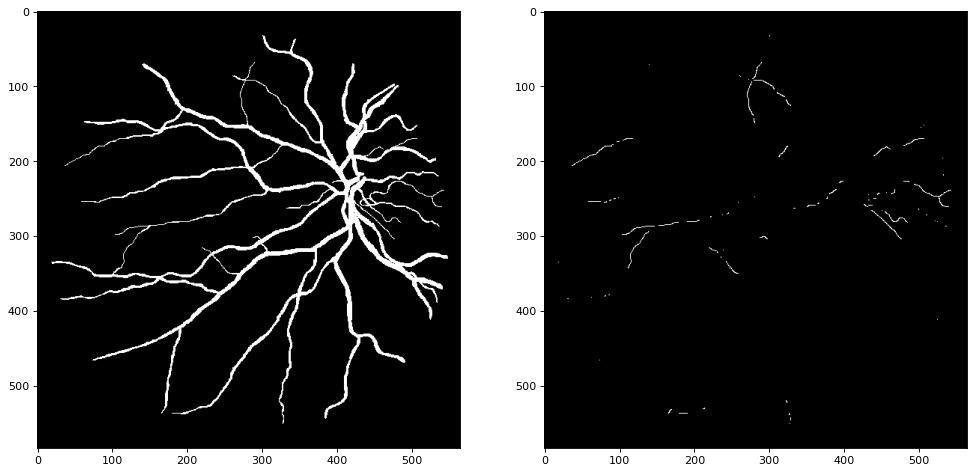

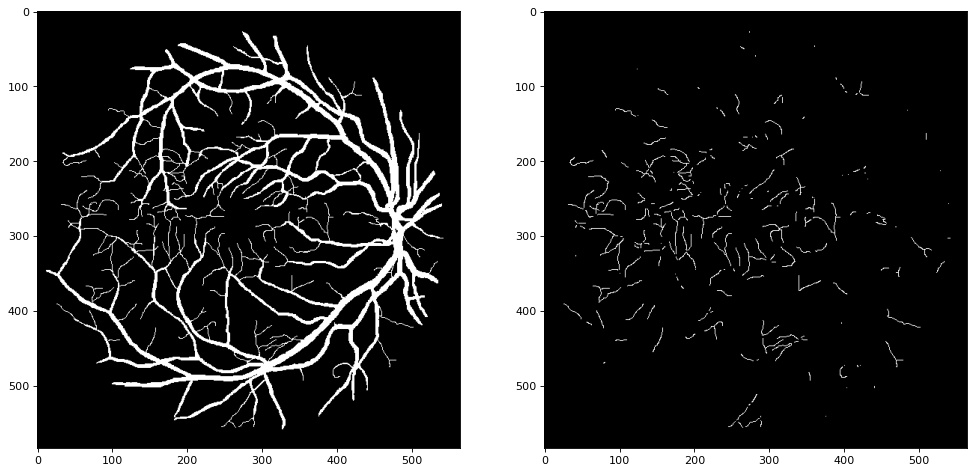

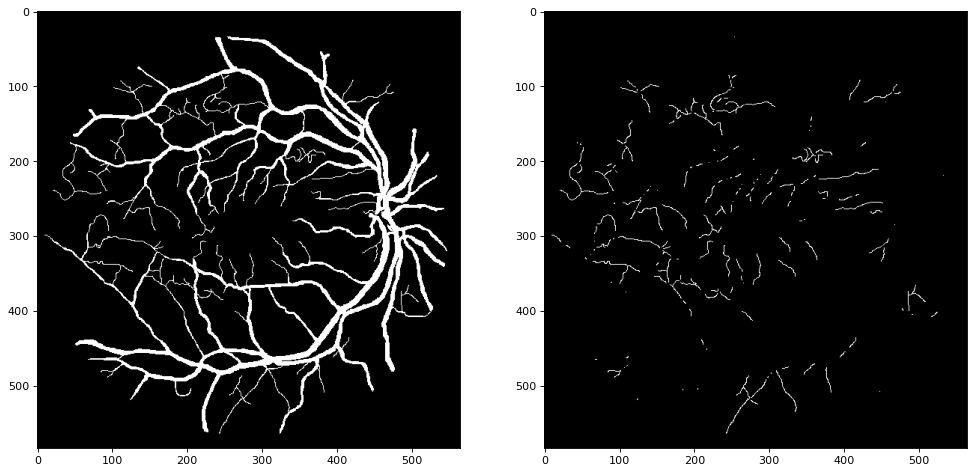

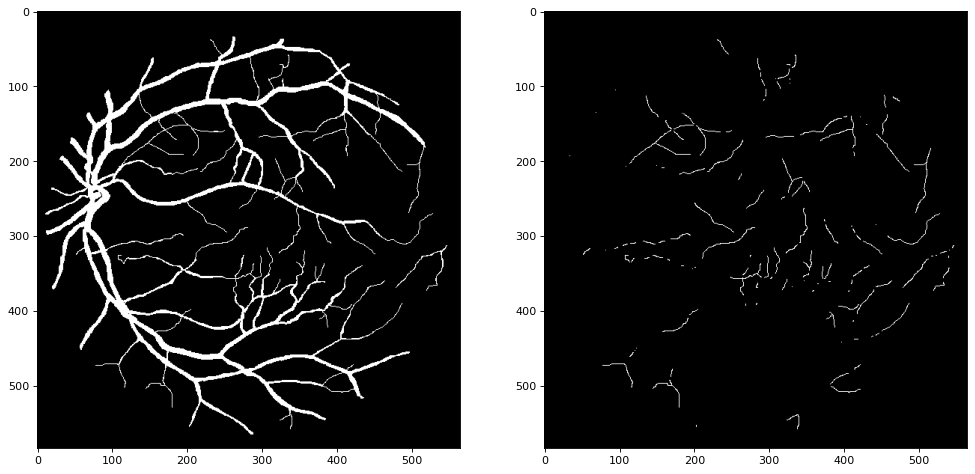

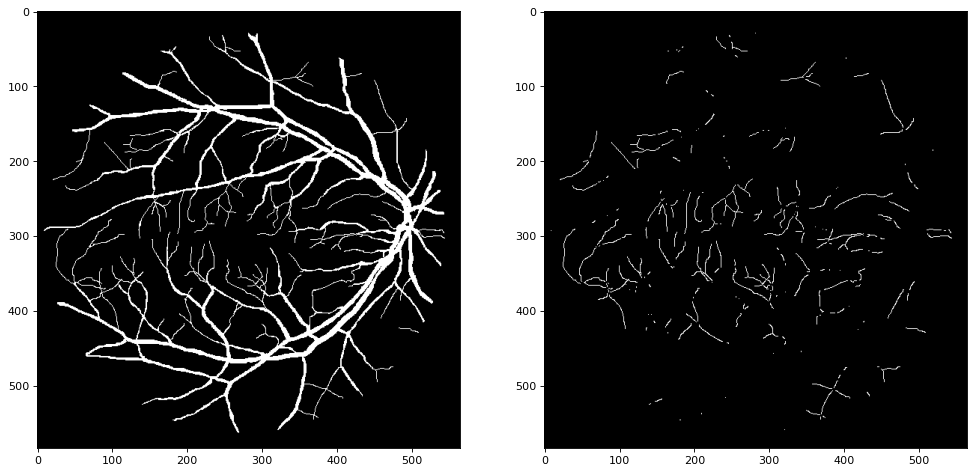

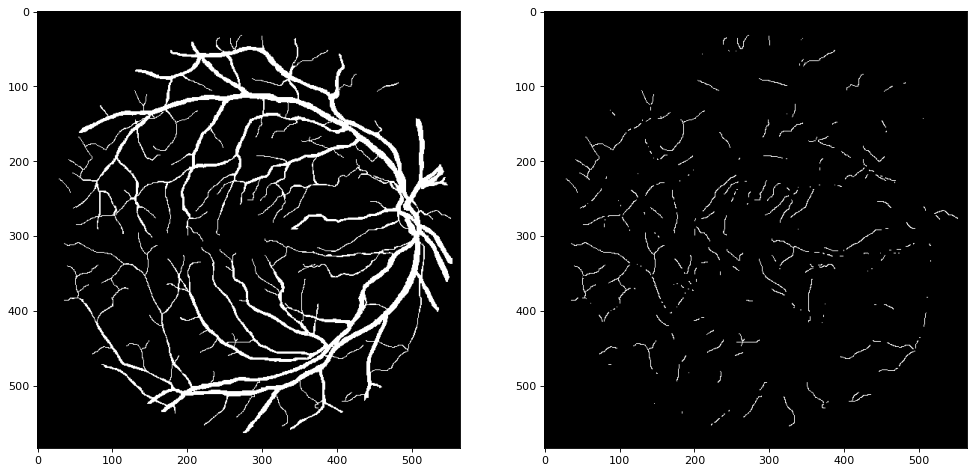

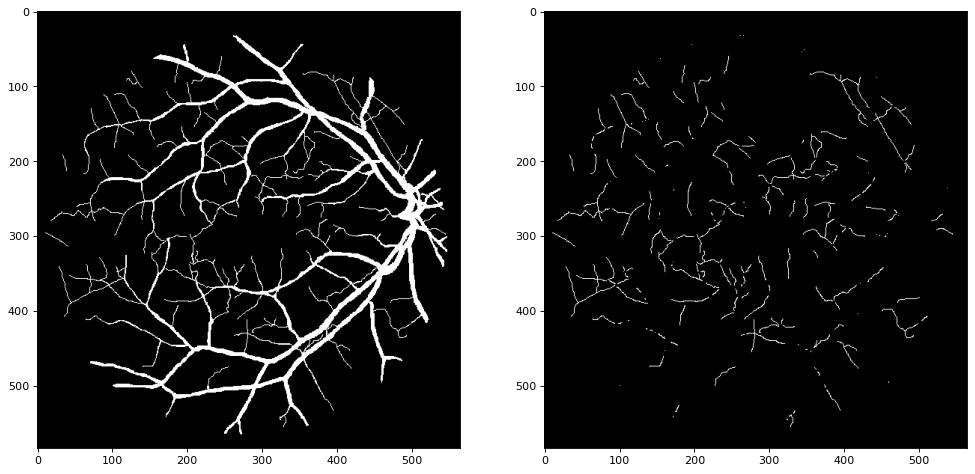

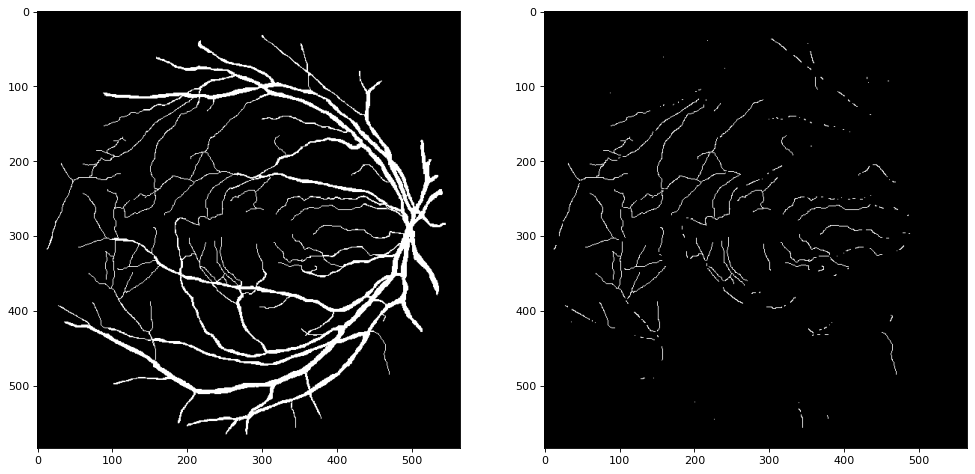

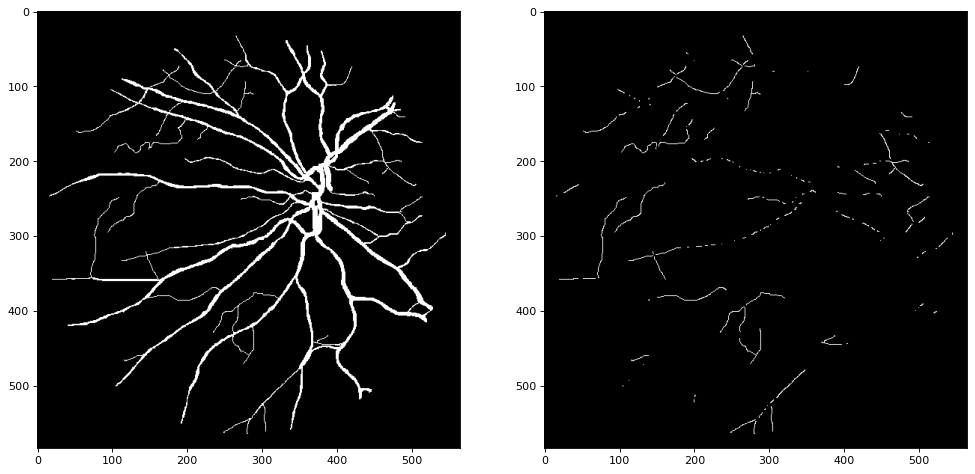

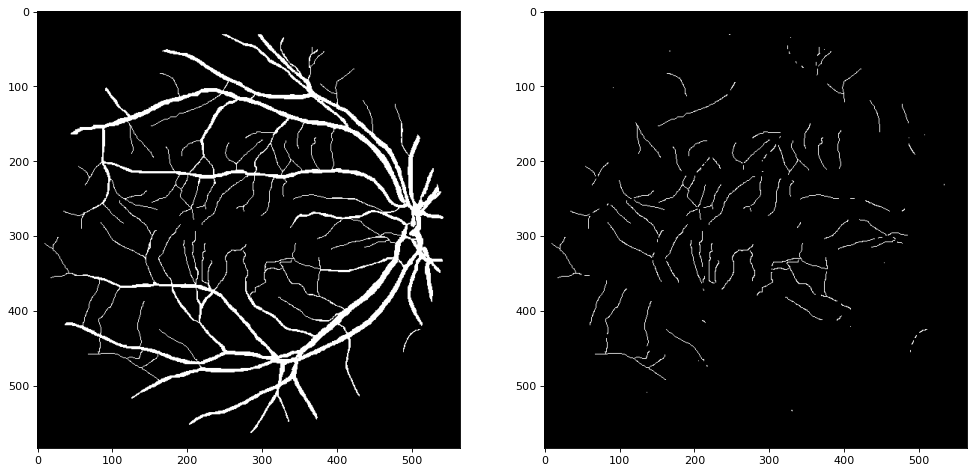

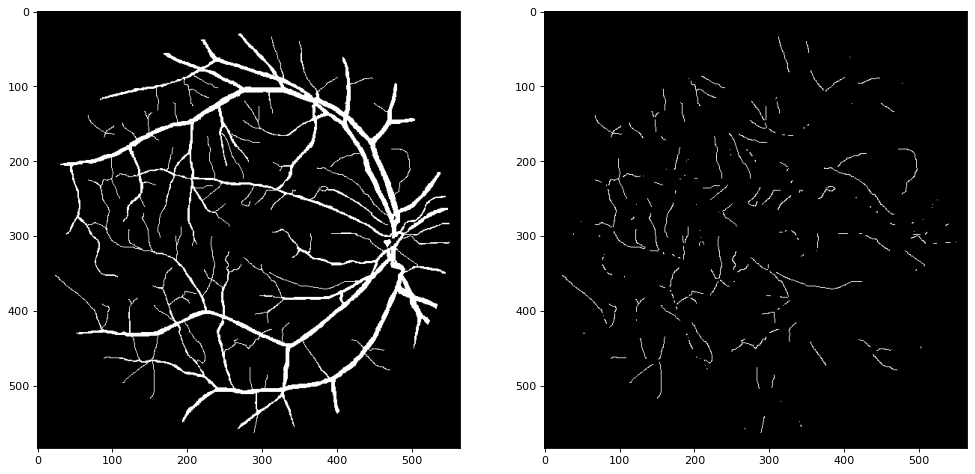

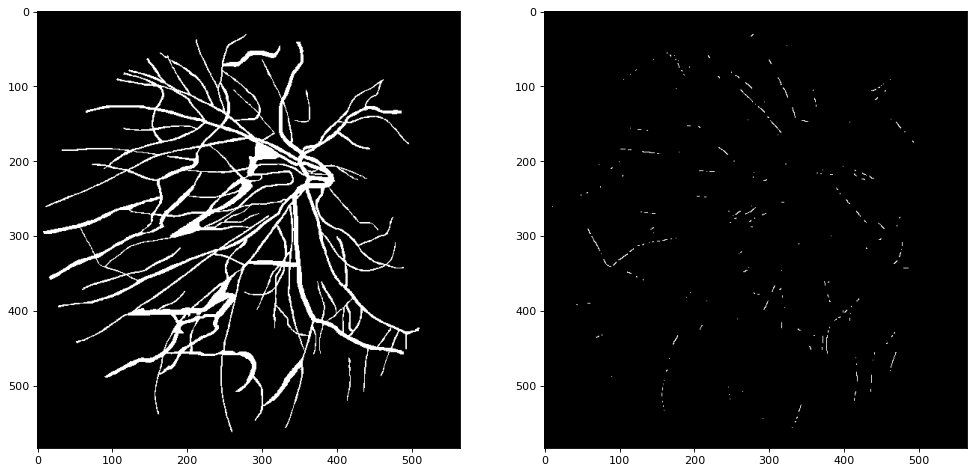

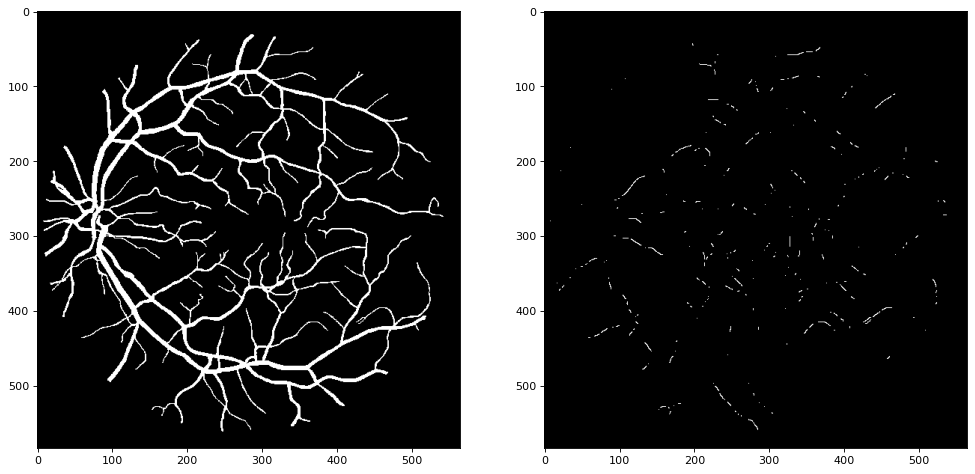

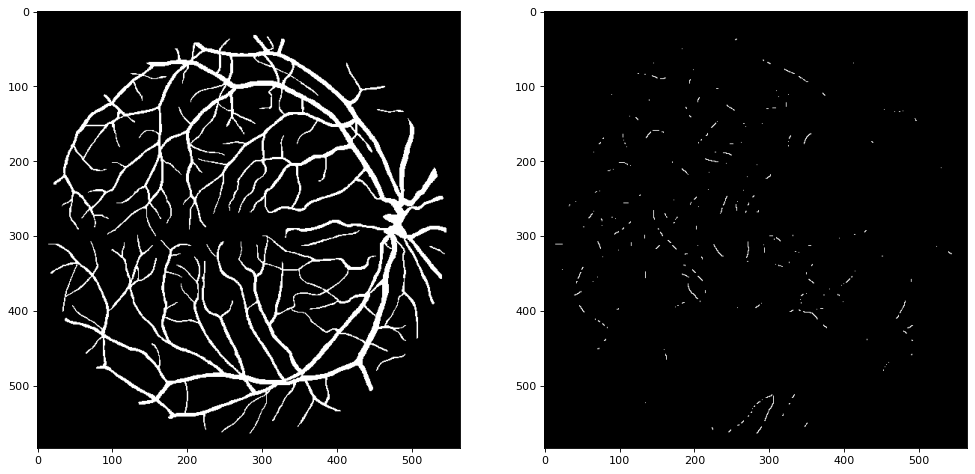

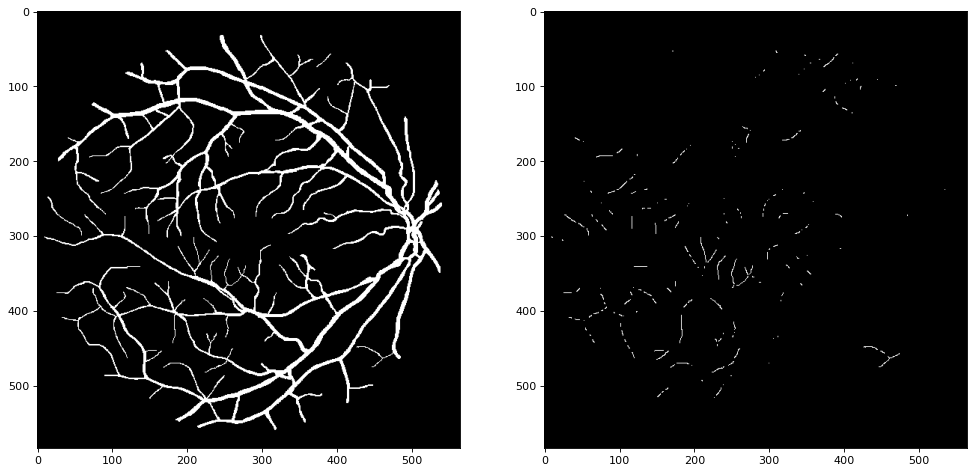

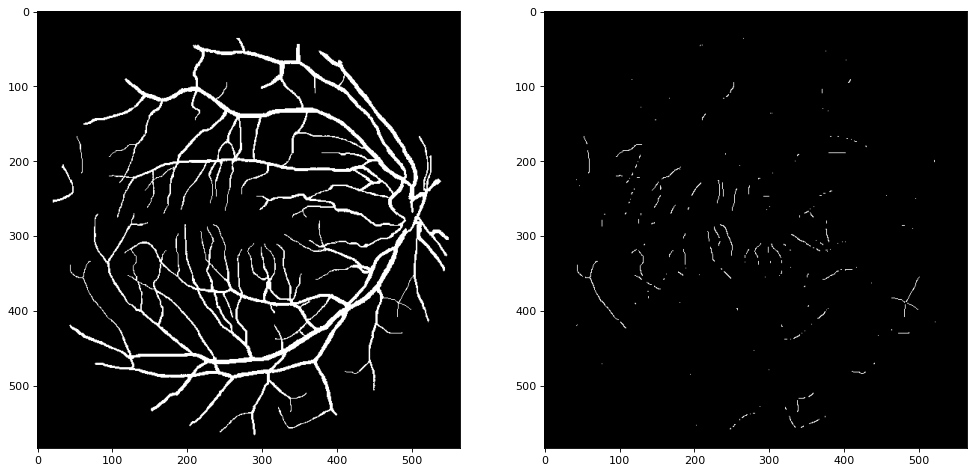

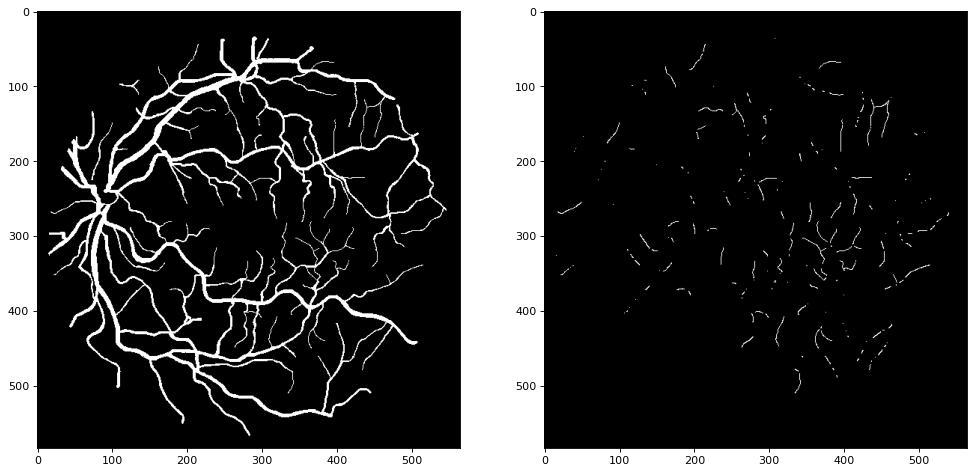

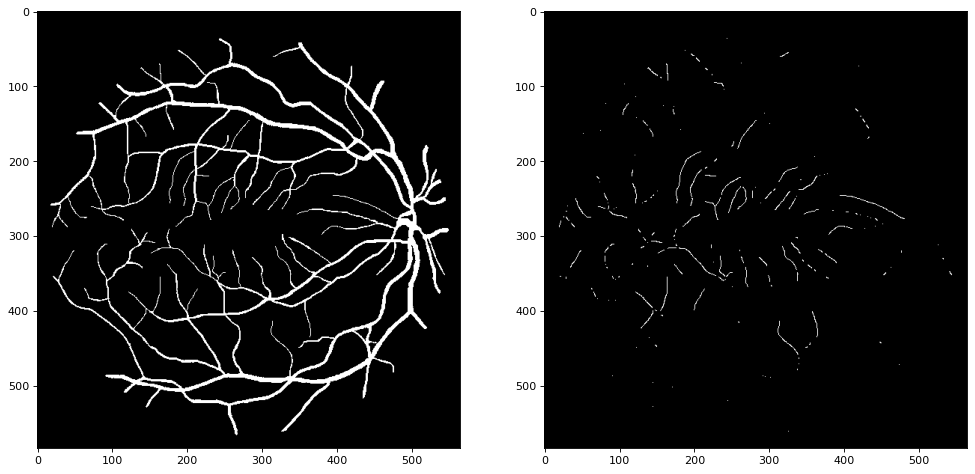

In [10]:
for label, new_label in zip(LABELS, NEW_LABELS):
    imshow_comparison(label, new_label)

In [11]:
import pandas as pd

thin_train = pd.DataFrame(
    np.concatenate([np.array(label, dtype=int)[MASKS[i]].ravel() for i, label in enumerate(NEW_LABELS) if i < 10],
                   axis=0).T).values.ravel()
thin_test = pd.DataFrame(
    np.concatenate([np.array(label, dtype=int)[MASKS[i]].ravel() for i, label in enumerate(NEW_LABELS) if i < 14 and i >= 10],
                   axis=0).T).values.ravel()

In [12]:
y_train = pd.DataFrame(
    np.concatenate([np.array(label, dtype=int)[MASKS[i]].ravel() for i, label in enumerate(LABELS) if i < 10],
                   axis=0).T).values.ravel()
y_test = pd.DataFrame(
    np.concatenate([np.array(label, dtype=int)[MASKS[i]].ravel() for i, label in enumerate(LABELS) if i < 14 and i >= 10],
                   axis=0).T).values.ravel()

In [13]:
weights_train = y_train.astype(float) + thin_train.astype(float)
weights_train[weights_train == 1] = 0.3
weights_train[weights_train == 2] = 0.7

weights_test = y_test.astype(float) + thin_test.astype(float)
weights_test[weights_test == 1] = 0.3
weights_test[weights_test == 2] = 0.7

In [14]:
import pickle
with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/weights.pkl', mode='wb') as f:
    pickle.dump([weights_train, weights_test], f)